# 5. Transformer recipe generator training

Note: This notebook is desinged to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer.

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.2 MB/s eta 0:00:00


Install Google Translate library to convert generated texts to other languages.

In [2]:
pip install -q googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 9.3 MB/s eta 0:00:00


Import modules and set random seeds.

In [3]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

import tensorflow as tf
from tensorflow.keras import layers, models
from googletrans import Translator

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [4]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print('Vocabulary size: {}'.format(VOCAB_SIZE))

Vocabulary size: 30522


Mount the google drive and load the trained model.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

transformer_model = models.load_model('/content/gdrive/My Drive/Transformer_recipe_generator')
attention_scores_model = models.load_model('/content/gdrive/My Drive/Transformer_recipe_generator_attention_scores')

Mounted at /content/gdrive


Define a function to generate new texts.

In [6]:
def sample_from(probs, temp):
    probs = probs ** (1 / temp)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs), probs


def gen_text(prompt, temp=0.1, lang='en'):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    for i in range(256):
        if i % 100 == 0 and i > 0:
            print('')
        probs = transformer_model.predict(np.array([input_ids]), verbose=0)[0][-1]
        next_token, _ = sample_from(probs, temp)
        next_word = tokenizer.convert_ids_to_tokens([next_token])[0]
        if next_word == '[SEP]':
            break
        print('.', end='')
        input_ids = np.append(input_ids, next_token)

    answer = tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(input_ids[1:])
    )
    print('')

    if lang == 'en':
        return answer, answer

    translator = Translator()
    translated = translator.translate(answer, dest=lang);
    return answer, translated.text

Define a function to show top 10 tokens following the input text.

In [7]:
def top_k(prompt, temp=0.1):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    probs = transformer_model.predict(np.array([input_ids]), verbose=0)[0][-1]
    _, probs = sample_from(probs, temp)
    probs = list(zip(probs, range(len(probs))))
    top_k = sorted(probs, reverse=True)[:10]
    probs = [p for p, _ in top_k]
    labels = [tokenizer.convert_ids_to_tokens([token])[0] for _, token in top_k]

    n = len(probs)
    fig = plt.figure(figsize=(6, 2))
    subplot = fig.add_subplot(1, 1, 1)
    subplot.set_xticks(range(n))
    subplot.set_xlim([-0.5, n - 0.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(labels)
    subplot.set_title(prompt, fontsize=11)
    _ = subplot.bar(range(n), probs, align='center')

Generate some sample texts.

In [8]:
gen_text('Recipe for beef', temp=1.0, lang='ja')

....................................................................................................
....................................................................................................
............


('recipe for beef enchiladas : preheat oven to 350 degrees f ( 175 degrees c ). drain grease. in a large bowl, cream cheese and cheese. in a medium bowl, combine the imitation crabmeat and lightly mix. with the ground beef. dip mixture in butter mixture. dip off artichoke hearts pieces in sour cream and shredded cheese. roll up into a 3 / 4 - inch pieces. spread 1 / 4 to 1 / 2 inch. sprinkle 1 / 2 of the ground beef bake in preheated oven until bubbly and cheese melts and cheddar cheese in a saucepan over medium - high heat. refried beans in a 3 cup mozzarella cheese. cover with aluminum foil and bake uncovered until heated through and rice is bubbling, about 15 minutes. an instant - read thermometer inserted into the center should read at least 160 degrees f ( 70 degrees c ). pour remaining 1 cup ketchup into a bowl ; top with about 5 minutes. serve warm or veggies.',
 'ビーフエンチラーダのレシピ：オーブンを350度F（175度C）に予熱します。グリースを排出します。大きなボウル、クリームチーズとチーズ。中程度のボウルに、模倣クラブミートを組み合わせて軽く混ぜます。牛ひき肉と。バター混合物に混合物を

In [9]:
gen_text('Recipe for beef', temp=0.5, lang='ja')

....................................................................................................
.............................................................................


('recipe for beef and italian sausage : place the ground beef in a large bowl, and cover with aluminum foil. place the aluminum foil on the grill, and cook until browned, about 10 minutes. drain fat and discard grease. stir in the ground beef, and onion ; cook and stir until tender, about 5 minutes. stir in the ground beef, and green beans. stir in the tomato sauce, tomato sauce, and tomato sauce into the pot ; bring to a boil. add the beans and simmer until beans are tender, about 10 minutes. stir in the tomatoes, tomato sauce, tomato sauce, and remaining 1 tablespoon water. stir the pasta into the pot. simmer for 1 hour, stirring occasionally, until the pasta is tender, about 1 hour. stir in the cooked pasta sauce, and 1 / 2 teaspoon salt, and pepper. adjust seasoning.',
 '牛肉とイタリアのソーセージのレシピ：牛ひき肉を大きなボウルに入れ、アルミホイルで覆います。アルミホイルをグリルに置き、茶色になるまで約10分間調理します。脂肪を排出し、グリースを捨てます。挽いた牛肉とタマネギをかき混ぜます。柔らかくなるまで約5分間調理してかき混ぜます。牛ひき肉と緑豆をかき混ぜます。トマトソース、トマトソース、トマトソースを鍋に入れます。沸騰させます。豆を加え、豆が柔らかくなるまで約10分間煮ます。トマト、ト

In [10]:
gen_text('Recipe for beef', temp=0.1, lang='ja')

....................................................................................................
...............................


('recipe for beef and onion soup : in a large pot over medium - high heat, and cook until browned, about 5 minutes. stir in the beef, and onion until tender, about 5 minutes. stir in the tomato sauce, and tomato sauce. bring to a boil, reduce heat to low, and simmer until the beans are tender, about 10 minutes. stir in the tomato soup, and simmer until the soup has thickened, about 5 minutes. stir in the tomato soup, and simmer until the soup has thickened, about 5 minutes. stir in the tomato paste, and simmer until the soup is heated through, about 5 minutes.',
 '牛肉と玉ねぎのスープのレシピ：中火で大きな鍋で、約5分間茶色になるまで調理します。牛肉をかき混ぜ、柔らかくなるまで玉ねぎ、約5分。トマトソースとトマトソースをかき混ぜます。沸騰させ、熱を低くし、豆が柔らかくなるまで約10分間煮ます。トマトスープをかき混ぜ、スープが濃くなるまで約5分間煮ます。トマトスープをかき混ぜ、スープが濃くなるまで約5分間煮ます。トマトペーストをかき混ぜ、約5分間スープが加熱されるまで煮ます。')

In [11]:
gen_text('Recipe for apple', temp=1.0, lang='ja')

....................................................................................................
..............................................................................


('recipe for apple cake : preheat oven to 350 degrees f ( 175 degrees c ). grease and flour three 13 x 13 inch pan. baking pan. in large bowl, cream together the butter and eggs until well blended. season with salt, and baking soda. mix in eggs. sift flour, baking soda, and salt together in a bowl. mix in the pumpkin mixture until just combined and smooth. divide 2 cans on large bowl, stir cranberries into the butter mixture. pour in a small bowl, beat flour mixture into egg mixture until smooth. combine wet ingredients are well - addition. stir in 1 / 3 / 4 cup. pour batter into prepared pan and bake for 25 minutes in preheated oven until a toothpick inserted into the center of a cake comes out clean or at least 30 minutes. cool completely before removing to wire racks to drain on wire rack.',
 'アップルケーキのレシピ：オーブンを350度F（175度C）に予熱します。グリースと小麦粉33 x 13インチパン。ベーキングパン。大きなボウルに、バターと卵をよく混ぜるまでクリームします。塩と重曹で味付けします。卵を混ぜます。小麦粉、重曹、塩をボウルにふるいにかけます。カボチャの混合物を混ぜ合わせて滑らかになるまで混ぜます。大きなボウルに2つの缶を分け、クランベリーをバターの混合物

In [12]:
gen_text('Recipe for apple', temp=0.5, lang='ja')

..........................................................................................


('recipe for apple cider : preheat oven to 350 degrees f ( 175 degrees c ). grease a 9x13 inch baking pan. combine sugar, baking powder, baking soda, and salt in a large bowl. mix the flour, baking powder, baking soda, and salt. stir in the nuts and raisins. pour into the prepared pan. bake in the preheated oven until lightly browned, about 60 minutes. cool completely.',
 'アップルサイダーのレシピ：オーブンを350度F（175度C）に予熱します。9x13インチのベーキングパンにグリースを塗ります。砂糖、ベーキングパウダー、重曹、塩を大きなボウルに混ぜます。小麦粉、ベーキングパウダー、重曹、塩を混ぜます。ナッツとレーズンをかき混ぜます。準備されたパンに注ぎます。約60分間、軽く茶色になるまで予熱したオーブンで焼きます。完全に涼しい。')

In [13]:
gen_text('Recipe for apple', temp=0.1, lang='ja')

....................................................................................................
........................................


('recipe for apple pie : preheat oven to 350 degrees f ( 175 degrees c ). in a large bowl, mix together the flour, baking powder, baking soda, and salt. set aside. in a large bowl, cream together the butter and sugar until light and fluffy. add eggs one at a time, beating well after each addition. stir in the vanilla extract, and nuts. stir in the vanilla extract. stir in the vanilla extract, and nuts. pour into the prepared pie shell. bake in the preheated oven until set, about 30 minutes. let cool completely, about 5 minutes. remove from oven and let cool completely, about 5 minutes. remove from oven and cool completely.',
 'アップルパイのレシピ：オーブンを350度F（175度C）に予熱します。大きなボウルに、小麦粉、ベーキングパウダー、重曹、塩を混ぜます。脇に置いてください。大きなボウルに、軽くふわふわになるまでバターと砂糖を一緒にクリームします。卵を一度に1つずつ加え、追加するたびによく鼓動します。バニラエキスとナッツをかき混ぜます。バニラエキスをかき混ぜます。バニラエキスとナッツをかき混ぜます。準備されたパイシェルに注ぎます。予熱したオーブンで、セットまで約30分間焼きます。約5分間、完全に冷まします。オーブンから取り出し、約5分間完全に冷まします。オーブンから取り出し、完全に冷まします。')

Show top 10 tokens for a sample text.

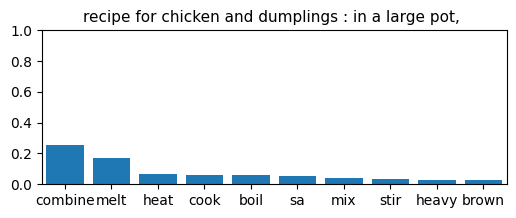

In [14]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=1.0)

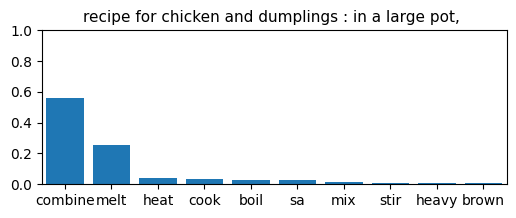

In [15]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.5)

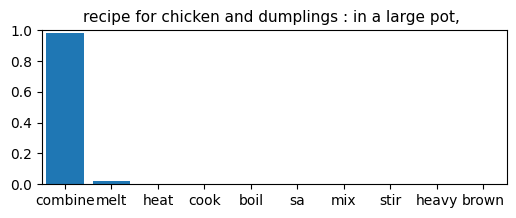

In [16]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.1)

Show attention weights (averaged over multiple attention heads) for the Transformer encoder layers.

In [17]:
prompts = [
    'recipe for chicken steak : in a large bowl, combine the chicken, onion,',
    'recipe for chicken breasts : mix the garlic powder in a small bowl.',
    'in a small bowl. stir vegetable soup and mix in chicken',
]

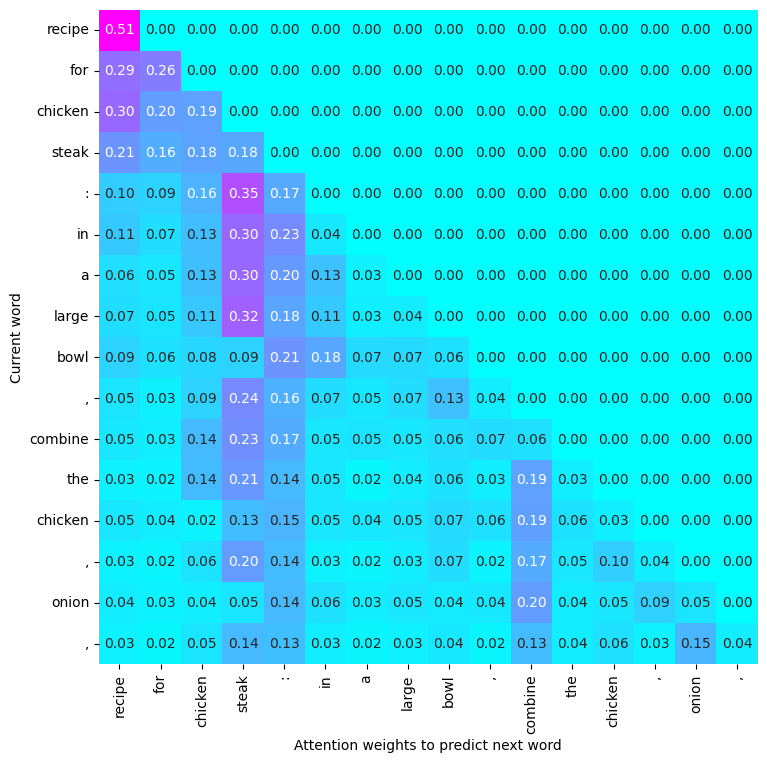

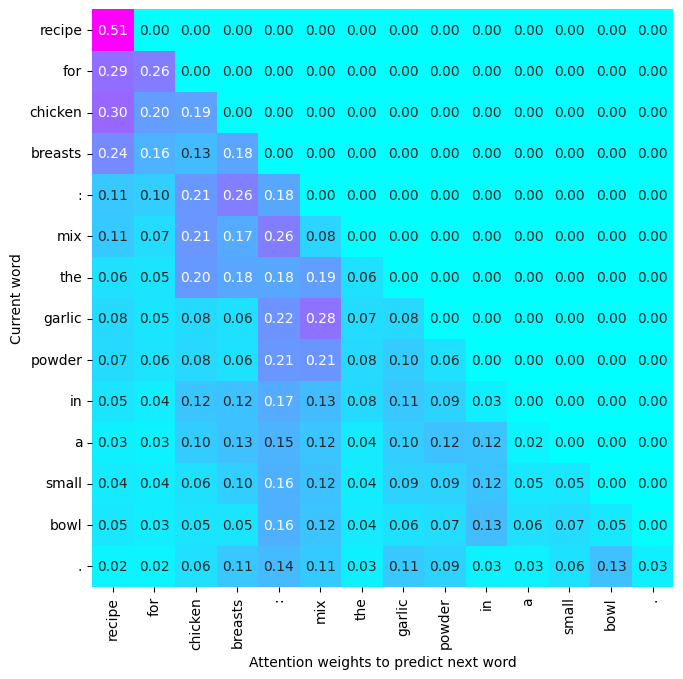

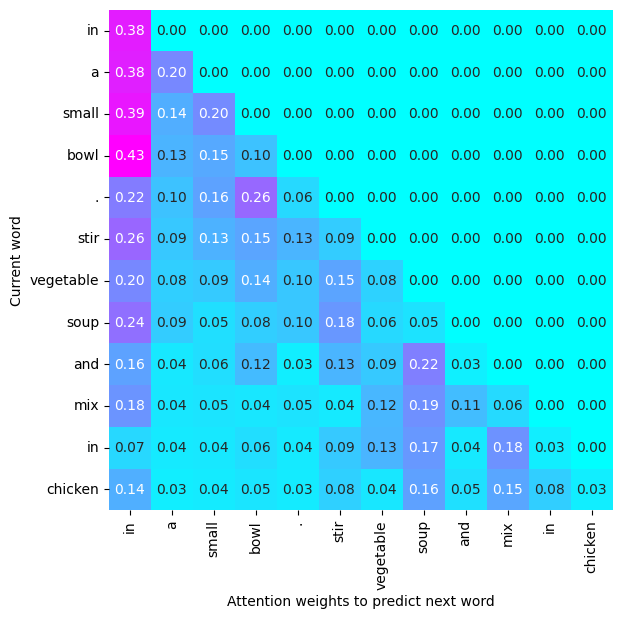

In [18]:
import seaborn as sns

for prompt in prompts:
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]
    _, attention_scores = attention_scores_model.predict(np.array([input_ids]), verbose=0)
    labels = tokenizer.convert_ids_to_tokens(input_ids)
    text_len = attention_scores.shape[-1]

    fig = plt.figure(figsize=(text_len/2, text_len/2))
    subplot = fig.add_subplot(1, 1, 1)
    heatmap = sns.heatmap(np.mean(attention_scores[0, :, 1:text_len, 1:text_len], axis=0),
                    ax = subplot,
                    xticklabels=labels[1:text_len], yticklabels=labels[1:text_len],
                    cmap='cool', cbar=False, annot=True, fmt='1.2f')
    _ = heatmap.set(xlabel='Attention weights to predict next word', ylabel='Current word')